<a href="https://colab.research.google.com/github/SangMin316/EEG_Data/blob/main/CHB_MIT_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

data augmentation

In [1]:
import numpy as np
def MAF(x,window):
    new_signals = np.zeros(x.shape)
    sample_num, T = x.shape
    for i in range(sample_num):
      noise = np.convolve(x[i], np.ones(window),'same')/window
      new_signals[i] = x[i] - noise
   
    return new_signals


def asln(x,a,b):

    C,T = x.shape
    noise = a*np.linspace(0,1,T) - b*np.ones(T)
    noise = noise*np.ones((C,1))
    n = np.random.randint(2)
    if n == 0:
      new_signals = x + noise
    else:
      new_signals = x - noise
    return new_signals

def apn(x,c,d):
    C,T = x.shape
    noise = np.linspace(-np.pi+d,np.pi+d,T) - d*np.ones(T)
    noise = c*np.sin(noise)*np.ones((C,1))
    new_signals = x + noise
    return new_signals

In [2]:
def augmented_data(x,window,a,b,c,d):
      # x = np.squeeze(x)
      batch,channel,t = x.shape
      x = np.reshape(x,(batch*channel,t))
      # print(x.shape)
      # x = x.numpy()
      samples, sequence_length = x.shape
      X = []
      Y = []
      X.append(x)

      x_maf = MAF(x,window)
      x_asln = asln(x,a,b)
      x_apn = apn(x,c,d)
      
      X.append(x_maf)
      X.append(x_asln)
      X.append(x_apn)

      #one-hot encoding
      original = [1,0,0,0]
      s_maf = [0,1,0,0]
      s_asln = [0,0,1,0]
      s_apn = [0,0,0,1]
      # print(x_apn.shape)
      Y.append(original*np.ones((samples,1)))
      Y.append(s_maf*np.ones((samples,1)))
      Y.append(s_asln*np.ones((samples,1)))
      Y.append(s_apn*np.ones((samples,1)))
      
      X = np.array(X)

      X = X.reshape(4*samples,sequence_length)
      # print(X.shape)
      Y = np.array(Y)
      Y = Y.reshape(4*samples,4)
      
      return X,Y 

In [3]:
sample = np.load('/content/drive/MyDrive/EEG_data/CHB_MIT/data/Data_Sample01.npy')
sample.shape

(123, 23, 256)

In [4]:
sample.shape

(123, 23, 256)

In [5]:
from scipy import signal

sample1 = signal.resample(sample, 200, axis=2)

In [6]:
sample1.shape

(123, 23, 200)

In [7]:
x,y= augmented_data(sample1,15,0.75,0,0.75,1.5)

In [8]:
x.shape

(11316, 200)

[1. 0. 0. 0.]
[0. 1. 0. 0.]
[0. 0. 1. 0.]
[0. 0. 0. 1.]


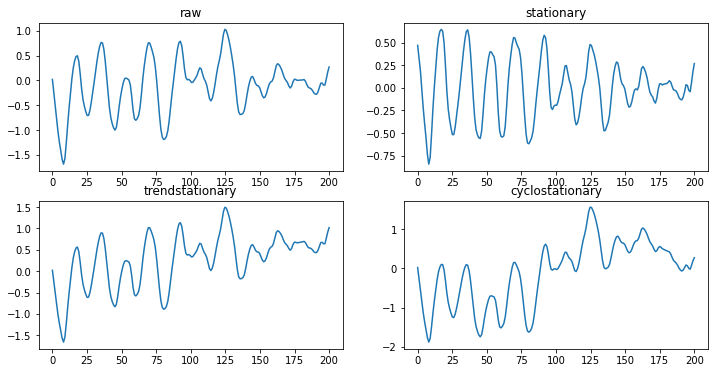

In [9]:
import matplotlib.pyplot as plt

sequence_length = 200
t = np.linspace(0,sequence_length,sequence_length)

plt.figure(figsize =(12, 6))
label = ['S1_raw','S2_raw','S1_stationary','S2_stationary',
         'S1_trendstationary','S2_trendstationary','S1_cyclostationary','S2_cyclostationary']


label = ['raw','stationary','trendstationary','cyclostationary']

for i in range(4):
  k = x[i*23*123]
  print(y[i*23*123])
  plt.subplot(2, 2, i+1)
  plt.plot(t,k)
  plt.title(label[i])
plt.savefig('agumented_signal_(15,06,06)')
plt.show()  

In [10]:
!pip install mne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
from scipy import signal
from torch.utils.data import Dataset
import torch

class CHB_MIT_Dataset(Dataset):
    def __init__(self, idxs, ssl=True, sfreq=200, ratio = None):
        #self.path = os.getcwd()
        self.path = '/content/drive/MyDrive/EEG_data/CHB_MIT/'

        data = []
        labels = []

        for idx in idxs:
            tmp = np.load(self.path + 'data/' + f'Data_Sample{idx:02d}.npy')
            y = np.load(self.path +  'label/' + f'Data_Label{idx:02d}.npy')

            if ratio != None:
                length = int(tmp.shape[0] * ratio)
                data.append(tmp[:length, :, :])
                labels.append(y[:length])
            else:
                data.append(tmp)
                labels.append(y)

        del tmp, y

        data = np.concatenate(data, axis=0)

        data = np.moveaxis(data, -1, 0)
        data = signal.resample(data, sfreq)

        self.data = np.moveaxis(data, 0, -1)
        self.labels = np.array(np.concatenate(labels, axis=0))
        self.ssl = ssl
        self.sfreq = sfreq

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, item):
        return self.data[item]

In [12]:
a = np.load('/content/drive/MyDrive/EEG_data/CHB_MIT/data/Data_Sample01.npy')

In [13]:
a.shape

(123, 23, 256)

In [14]:
idx = list(range(1,21))
CHBdataset = CHB_MIT_Dataset(idx)

train_size = int(0.8 * len(CHBdataset))
val_size = int(0.1 * len(CHBdataset))
test_size = len(CHBdataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(CHBdataset, [train_size, val_size, test_size],
                                                                         generator=torch.Generator().manual_seed(123456))

In [15]:
from torch.utils.data import DataLoader

trainLoader = DataLoader(train_dataset, batch_size = 3, shuffle=False)

In [16]:
for batch_idx, batch in enumerate(trainLoader):
  print( 'n:',batch_idx, 'values: ' , batch.shape)
  if batch_idx >= 2:
    break

n: 0 values:  torch.Size([3, 23, 200])
n: 1 values:  torch.Size([3, 23, 200])
n: 2 values:  torch.Size([3, 23, 200])


model

In [17]:
import torch
import torch.nn as nn



class feature_extractor3(nn.Module):
    def __init__(self):
        super(feature_extractor3,self).__init__()
        
        self.channels = 1 # we use only single channel 
        
        # Activation functions
        self.activation = nn.LeakyReLU()
        self.bn = nn.BatchNorm1d(1)

        # self.conv2t = nns.SeparableConv1d(16,32,10,padding ='same') (in_channels, out_channels, kernel size,,,) 

        self.softmax = nn.Softmax()
        self.conv1t = nn.Conv1d(1,10, 30, padding ='same') #in_channels, out_channels, kernel_size, 
        self.conv1s = nn.Conv1d(10,10,self.channels)
        self.conv2t = nn.Conv1d(10,20,15,padding ='same') 
        self.conv2s = nn.Conv1d(20,20,self.channels)
        self.conv3t = nn.Conv1d(20,34,5,padding ='same')
        self.conv3s = nn.Conv1d(34,34,self.channels)
        
                  
        # Flatteninig
        self.flatten = nn.Flatten()

        # Dropout
        self.dropout = nn.Dropout(0.5)

        # Decision making
        self.Linear = nn.Linear(12800 ,4) # 

      
    def embedding(self, x):
        x = self.bn(x)
        x = self.activation(self.conv1t(x))
        f1 = self.activation(self.conv1s(x))

        x = self.activation(self.conv2t(x))
        f2 = self.activation(self.conv2s(x))

        x = self.activation(self.conv3t(x))
        f3 = self.activation(self.conv3s(x))
        
        # multi-scale feature representation by exploiting intermediate features
        feature = torch.cat([f1, f2, f3],dim = 1 )
        
        return feature

    def classifier(self, feature):
        # Flattening, dropout, mapping into the decision nodes
        feature = self.flatten(feature)
        feature = self.dropout(feature)
        y_hat = self.softmax(self.Linear(feature))
        return y_hat    

    def forward(self, x):
        feature = self.embedding(x)
        y_hat = self.classifier(feature)
        return y_hat

parameter setting

In [18]:
import os

# batch size
batch_size = 128
learning_rate = 0.001
epochs = 25

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#"cpu"



In [19]:
print(device)

cuda:0


In [20]:
trainLoader = DataLoader(train_dataset, batch_size = batch_size, shuffle=False)
valLoader = DataLoader(val_dataset, batch_size = batch_size, shuffle=False)
testLoader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

batch단위로 loss를 계산하는 방법입니다.

In [21]:
def augmented_data(x,window,a,b,c,d):
      # x = np.squeeze(x)
      batch,channel,t = x.shape
      x = np.reshape(x,(batch*channel,t))
      # print(x.shape)
      x = x.numpy()
      samples, sequence_length = x.shape
      X = []
      Y = []
      X.append(x)

      x_maf = MAF(x,window)
      x_asln = asln(x,a,b)
      x_apn = apn(x,c,d)
      
      X.append(x_maf)
      X.append(x_asln)
      X.append(x_apn)

      #one-hot encoding
      original = [1,0,0,0]
      s_maf = [0,1,0,0]
      s_asln = [0,0,1,0]
      s_apn = [0,0,0,1]
      # print(x_apn.shape)
      Y.append(original*np.ones((samples,1)))
      Y.append(s_maf*np.ones((samples,1)))
      Y.append(s_asln*np.ones((samples,1)))
      Y.append(s_apn*np.ones((samples,1)))
      
      X = np.array(X)

      X = X.reshape(4*samples,sequence_length)
      # print(X.shape)
      Y = np.array(Y)
      Y = Y.reshape(4*samples,4)
      
      return X,Y 

In [26]:
class Temporal_Trend_Identification_Task_Loss(torch.nn.modules.loss._Loss):
    def __init__(self, device = None):
        super().__init__()
        self.device = device

    def forward(self, batch, encoder, train):
        acc = 0
        x, y = augmented_data(batch,window = 15, a= 0.75, b = 0, c = 0.75, d= 1.5)
        c,t = x.shape
        x = np.reshape(x,(c,1,t))
        CrossEL = torch.nn.CrossEntropyLoss()
        pred = encoder.forward(torch.Tensor(x).to(device))
        y = torch.Tensor(y).to(device)
        
    
        loss = CrossEL(pred, torch.Tensor(y).to(device))
        if train:
            loss.backward(retain_graph=True)
        
        _, y =  torch.max(y, 1)     
        _, predicted = torch.max(pred, 1) 
        
        acc = (predicted == y).sum().item()
        acc = acc/c #acc/(batch*channels*4(augmented))
        del x
        del y
        return loss, acc    
        

gpu memory 정리

In [23]:
import gc
gc.collect()

66

In [24]:
torch.cuda.empty_cache() # GPU 캐시 데이터 삭제

model, loss, optimizer settiong

In [27]:
model = feature_extractor3().to(device)
#model.to(device)
criterion = Temporal_Trend_Identification_Task_Loss(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [28]:
print(model)

feature_extractor3(
  (activation): LeakyReLU(negative_slope=0.01)
  (bn): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (softmax): Softmax(dim=None)
  (conv1t): Conv1d(1, 10, kernel_size=(30,), stride=(1,), padding=same)
  (conv1s): Conv1d(10, 10, kernel_size=(1,), stride=(1,))
  (conv2t): Conv1d(10, 20, kernel_size=(15,), stride=(1,), padding=same)
  (conv2s): Conv1d(20, 20, kernel_size=(1,), stride=(1,))
  (conv3t): Conv1d(20, 34, kernel_size=(5,), stride=(1,), padding=same)
  (conv3s): Conv1d(34, 34, kernel_size=(1,), stride=(1,))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.5, inplace=False)
  (Linear): Linear(in_features=12800, out_features=4, bias=True)
)


learing

In [29]:
import matplotlib.pyplot as plt
loss_tr = []
loss_val = []
acc_tr = []
acc_val = []
for epoch in range(epochs):
    loss_ep = 0  # add batch loss in epoch
    acc_ep = 0
    for batch_idx, batch in enumerate(trainLoader):
        optimizer.zero_grad()
        loss_batch, acc_batch = criterion.forward(batch, model, train = True)
        # print(batch_idx)
        optimizer.step()
        loss_ep += loss_batch.item()
        acc_ep += acc_batch

    loss_tr.append((loss_ep)/len(trainLoader))
    acc_tr.append((acc_ep)/len(trainLoader))

    loss_ep_val = 0
    acc_ep_val = 0
    for batch_idx, batch in enumerate(valLoader):
        loss_batch_val, acc_batch_val = criterion.forward(batch, model, train = False)
        loss_ep_val += loss_batch_val.item()
        acc_ep_val += acc_batch_val
    
    loss_val.append((loss_ep_val)/len(valLoader))
    acc_val.append((acc_ep_val)/len(valLoader))
    print("epoch : ", epoch, "  train loss : ", loss_tr[epoch], 'train acc : ', acc_tr[epoch], "    val loss : ", loss_val[epoch], 'val acc : ', acc_val[epoch])


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:304: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:882.)
  self.padding, self.dilation, self.groups)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


epoch :  0   train loss :  1.143796647970493 train acc :  0.5919380099067599     val loss :  0.9908773005008698 val acc :  0.7489668251811594
epoch :  1   train loss :  0.98680468247487 train acc :  0.7555382089604238     val loss :  0.95030477643013 val acc :  0.790329200634058
epoch :  2   train loss :  0.9478068695618556 train acc :  0.7975503889226714     val loss :  0.9348384737968445 val acc :  0.8065061707427537
epoch :  3   train loss :  0.9501472619863657 train acc :  0.7891375212197224     val loss :  0.9264277964830399 val acc :  0.8136180932971013
epoch :  4   train loss :  0.9456683420217954 train acc :  0.7970856136617006     val loss :  0.9389173835515976 val acc :  0.7995782382246377
epoch :  5   train loss :  0.9358078103799087 train acc :  0.8071349930640012     val loss :  0.9228248447179794 val acc :  0.8181683084239131
epoch :  6   train loss :  0.930419786618306 train acc :  0.8118554905239688     val loss :  0.9254183620214462 val acc :  0.8222302423007247
epoch 

result save and plot

In [30]:
import pandas as pd
col = ['loss_tr','loss_val','acc_tr','acc_val']
data = np.array([loss_tr,
                 loss_val,
                 acc_tr,
                 acc_val])
print(data.shape)
data = np.transpose(data)
df = pd.DataFrame(data = data, columns= col)
df.to_excel('CHB_100Hz_(20,0.75,0.75).xlsx', index = False)

(4, 25)


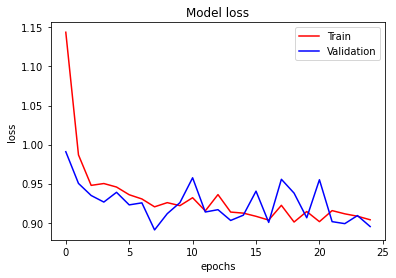

In [31]:
# plt.figure(figsize =(15, 10))
plt.plot(range(epochs), loss_tr, color='red')
plt.plot(range(epochs), loss_val, color='blue')
plt.title('Model loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig('CHB_100Hz_(20,0.75,0.75)_loss_1s.png',bbox_inches = 'tight')
plt.show()


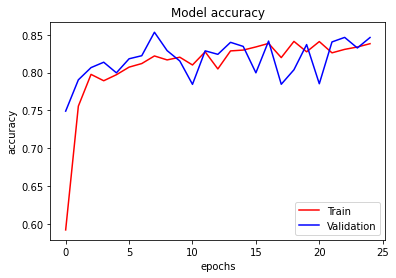

In [32]:
# plt.figure(figsize =(15, 10))
plt.plot(range(epochs), acc_tr, color='red')
plt.plot(range(epochs), acc_val, color='blue')
plt.title('Model accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.savefig('CHB_100Hz_(20,0.75,0.75)_accuracy_1s.png',bbox_inches = 'tight')
plt.show()

In [33]:
def predict( batch, encoder):
  x, y = augmented_data(batch,window = 15 , a= 0.75, b = 0, c = 0.75, d= 1.5)
  c,t = x.shape
  # print('bj',x.shape)
  x = np.reshape(x,(c,1,t))
      
  rept = encoder.forward(torch.Tensor(x).to(device))
  
  rept = rept.cpu().detach().numpy()
  
  return rept, y

In [34]:
Y_hat = []
Y = []
for batch_idx, batch in enumerate(testLoader):
  y_hat,y = predict(batch, encoder = model)

  Y_hat.extend(y_hat)
  Y.extend(y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [35]:
Y_hat = np.array(Y_hat)
print(Y_hat.shape)

Y = np.array(Y)
print(Y.shape)

(37628, 4)
(37628, 4)


In [36]:
Y_tensor = torch.Tensor(Y)
_, Y_tensor =  torch.max(Y_tensor, 1) 
Y_hat_tensor = torch.Tensor(Y_hat)


_, predicted = torch.max(Y_hat_tensor, 1) 
# print(predicted.shape)
# print(y.shape)
print(predicted.shape)
correct = (predicted == Y_tensor).sum().item()
wrong = len(Y) - correct

torch.Size([37628])


In [37]:
correct, wrong


(31296, 6332)

In [38]:
print('accuracy:',correct/(correct + wrong))


accuracy: 0.8317210587860104


In [39]:
# confusion matrix 사용을 위한 라이브러리
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(Y_tensor, predicted)
print(conf_matrix)

[[6313  799 1276 1019]
 [  31 9376    0    0]
 [1629    1 6828  949]
 [ 384    1  243 8779]]


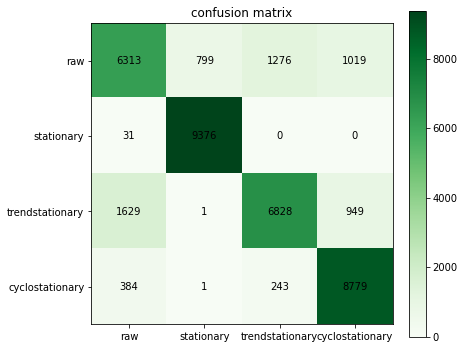

In [40]:
#one-hot encoding
      # original = [1,0,0,0]
      # s_maf = [0,1,0,0]
      # s_asln = [0,0,1,0]
      # s_apn = [0,0,0,1]

title = 'confusion matrix'
cmap=plt.cm.Greens
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=cmap)  # , cmap=plt.cm.Greens
plt.title(title, size=12)
plt.colorbar(fraction=0.05, pad=0.05)
tick_marks = np.arange(4, 4)
plt.xticks(np.arange(4), ('raw','stationary','trendstationary','cyclostationary'))
plt.yticks(np.arange(4), ('raw','stationary','trendstationary','cyclostationary'))


fmt = 'd' 
thresh = 1
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], fmt),
                 ha="center", va="center", color="black" if conf_matrix[i, j] > thresh else "black")  #horizontalalignment
plt.savefig('Sleepedf+MASS_confusionmatrix_10s',bbox_inches = 'tight')

In [44]:
torch.cuda.empty_cache() # GPU 캐시 데이터 삭제

In [45]:
rept_train = []
for batch_idx, batch in enumerate(trainLoader):
  b,c,t = batch.shape
  batch = np.reshape(batch,(int(b*c),1,t))
  rept = model.embedding(torch.Tensor(batch.float()).to(device))
  rept = rept.cpu().detach().numpy()
  # rept = model.embedding(batch.float())
  # rept = model.embedding(torch.Tensor(batch)
  rept = np.reshape(rept,(b,c,64,t))
  print('rept:',rept.shape)
  rept_train.extend(rept)

rept: (128, 23, 64, 200)
rept: (128, 23, 64, 200)
rept: (128, 23, 64, 200)
rept: (128, 23, 64, 200)
rept: (128, 23, 64, 200)
rept: (128, 23, 64, 200)
rept: (128, 23, 64, 200)
rept: (128, 23, 64, 200)
rept: (128, 23, 64, 200)
rept: (128, 23, 64, 200)
rept: (128, 23, 64, 200)
rept: (128, 23, 64, 200)
rept: (128, 23, 64, 200)
rept: (128, 23, 64, 200)
rept: (128, 23, 64, 200)
rept: (128, 23, 64, 200)
rept: (128, 23, 64, 200)
rept: (128, 23, 64, 200)
rept: (128, 23, 64, 200)
rept: (128, 23, 64, 200)
rept: (128, 23, 64, 200)
rept: (128, 23, 64, 200)
rept: (128, 23, 64, 200)
rept: (128, 23, 64, 200)
rept: (128, 23, 64, 200)
rept: (66, 23, 64, 200)


In [46]:
rept_train = np.array(rept_train)
print(rept_train.shape)

(3266, 23, 64, 200)


In [47]:
rept_val = []
for batch_idx, batch in enumerate(valLoader):
  b,c,t = batch.shape
  batch = np.reshape(batch,(int(b*c),1,t))
  rept = model.embedding(torch.Tensor(batch.float()).to(device))
  rept = rept.cpu().detach().numpy()
  # rept = model.embedding(batch.float())
  # rept = model.embedding(torch.Tensor(batch))
  rept = np.reshape(rept,(b,c,64,t))
  print('rept:',rept.shape)
  rept_val.extend(rept)

rept: (128, 23, 64, 200)
rept: (128, 23, 64, 200)
rept: (128, 23, 64, 200)
rept: (24, 23, 64, 200)


In [48]:
rept_val = np.array(rept_val)
print(rept_val.shape)

(408, 23, 64, 200)


In [49]:
rept_test = []
for batch_idx, batch in enumerate(testLoader):
  b,c,t = batch.shape
  batch = np.reshape(batch,(int(b*c),1,t))
  rept = model.embedding(torch.Tensor(batch.float()).to(device))
  rept = rept.cpu().detach().numpy()
  # rept = model.embedding(batch.float())
  # rept = model.embedding(torch.Tensor(batch))
  rept = np.reshape(rept,(b,c,64,t))
  print('rept:',rept.shape)
  rept_test.extend(rept)

rept: (128, 23, 64, 200)
rept: (128, 23, 64, 200)
rept: (128, 23, 64, 200)
rept: (25, 23, 64, 200)


In [50]:
rept_test = np.array(rept_test)
print(rept_test.shape)

(409, 23, 64, 200)


In [51]:
GAP_tr = np.transpose(rept_train,(0,2,1,3))
print(GAP_tr .shape)
GAP_tr  = torch.tensor(GAP_tr )
GAP_tr  = torch.mean(GAP_tr ,2)
print(GAP_tr .shape)
GAP_tr  = torch.mean(GAP_tr ,2)
print(GAP_tr .shape)

(3266, 64, 23, 200)
torch.Size([3266, 64, 200])
torch.Size([3266, 64])


In [52]:
def GAP(x):
  a = np.transpose(x,(0,2,1,3))
  a = torch.tensor(a)
  a = torch.mean(a,2)
  a = torch.mean(a,2)
  return a

In [53]:
np.save('GAP_rept_train_(20,0.75,0.75).npy',GAP(rept_train))
np.save('GAP_rept_val_(20,0.75,0.75).npy',GAP(rept_val))
np.save('GAP_rept_test_(20,0.75,0.75).npy',GAP(rept_test))

In [54]:
torch.save(model,'Temporal_(15,0.75,0.75)_200Hz.pt')

In [42]:
torch.save(model.state_dict(),'Temporal_(15,0.75,0.75)_200Hz_stat_dict.pt')

In [55]:
model2 = torch.load('/content/Temporal_(20,0.5,0.5).pt')

In [58]:
print(model2)

feature_extractor3(
  (activation): LeakyReLU(negative_slope=0.01)
  (bn): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (softmax): Softmax(dim=None)
  (conv1t): Conv1d(1, 10, kernel_size=(30,), stride=(1,), padding=same)
  (conv1s): Conv1d(10, 10, kernel_size=(1,), stride=(1,))
  (conv2t): Conv1d(10, 20, kernel_size=(15,), stride=(1,), padding=same)
  (conv2s): Conv1d(20, 20, kernel_size=(1,), stride=(1,))
  (conv3t): Conv1d(20, 34, kernel_size=(5,), stride=(1,), padding=same)
  (conv3s): Conv1d(34, 34, kernel_size=(1,), stride=(1,))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.5, inplace=False)
  (Linear): Linear(in_features=6400, out_features=4, bias=True)
)


In [56]:
model1 = torch.load('/content/Temporal_(20,0.5,0.5)_stat_dict.pt')

In [57]:
print(model1)

OrderedDict([('bn.weight', tensor([1.0369], device='cuda:0')), ('bn.bias', tensor([-0.0030], device='cuda:0')), ('bn.running_mean', tensor([0.0033], device='cuda:0')), ('bn.running_var', tensor([0.7601], device='cuda:0')), ('bn.num_batches_tracked', tensor(394, device='cuda:0')), ('conv1t.weight', tensor([[[ 6.0133e-02,  1.4535e-02, -1.0721e-01, -1.1851e-01,  8.3008e-02,
          -2.0898e-01, -6.0504e-02, -1.1271e-01, -5.3382e-02, -4.1050e-04,
          -3.3932e-02, -1.3404e-01, -8.7082e-02, -1.2835e-01, -1.0662e-01,
          -1.5705e-01, -1.6466e-01, -4.5351e-02,  3.7885e-02,  5.1823e-02,
          -2.1917e-03,  1.1939e-01,  1.6786e-02, -5.5675e-02, -6.2087e-03,
           1.1556e-01, -1.8758e-01,  7.7098e-02,  2.8976e-02, -1.7761e-01]],

        [[ 2.2523e-01,  2.2082e-01,  2.2530e-01, -5.1540e-02, -3.9795e-02,
           4.7824e-04,  1.7888e-01, -6.3165e-03,  7.9118e-04,  1.6774e-01,
           7.0141e-02, -2.4594e-02, -1.3877e-02,  1.8743e-01, -1.5754e-01,
           1.7917e-01, 